In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.models import load_model

In [38]:
def lstm_prep(df,window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

def predict_lstm(X_train, X_val, X_test, model):
    test_prob = model.predict(X_test)
    test_pred = np.argmax(test_prob, axis=1)
    train_prob = model.predict(X_train)
    train_pred = np.argmax(train_prob, axis=1)
    val_prob = model.predict(X_val)
    val_pred = np.argmax(val_prob, axis=1)
    return test_pred, test_prob, train_pred, train_prob, val_pred, val_prob

def cfm_metrics(test_cfm):
    positive = np.sum(np.diag(test_cfm))
    total_samples = np.sum(test_cfm)
    negative = total_samples - positive
    return positive, negative

def classification_results(y_test, y_train, y_val, model, train_pred, val_pred, test_pred, train_prob, val_prob, test_prob):
    test_cfm = confusion_matrix(y_test, test_pred)
    val_cfm = confusion_matrix(y_val, val_pred)
    train_cfm = confusion_matrix(y_train, train_pred)

    train_cfm_summary = cfm_metrics(train_cfm)
    test_cfm_summary = cfm_metrics(test_cfm)
    val_cfm_summary = cfm_metrics(val_cfm)

    train_val_test = pd.DataFrame([[train_cfm_summary[0] / (train_cfm_summary[1] + train_cfm_summary[0]), log_loss(y_train, train_prob), roc_auc_score(y_train, train_prob, multi_class='ovr')],
                                      [val_cfm_summary[0] / (val_cfm_summary[1] + val_cfm_summary[0]), log_loss(y_val, val_prob), roc_auc_score(y_val, val_prob, multi_class='ovr')],
                                      [test_cfm_summary[0] / (test_cfm_summary[1] + test_cfm_summary[0]), log_loss(y_test, test_prob), roc_auc_score(y_test, test_prob, multi_class='ovr')]],
                                     columns=['Accuracy', 'Log Loss', 'ROC_AUC'], index=['Train', 'Validation', 'Test']).T
    print(train_val_test)
    print('Training: ')
    print(classification_report(y_train, train_pred))
    print('Validation: ')
    print(classification_report(y_val, val_pred))
    print('Testing: ')
    print(classification_report(y_test, test_pred))

# SPY

In [45]:
spy = pd.read_pickle('SPY.pkl')
spy['LABEL'] = spy['LABEL'].shift(-1)
spy = spy.dropna()

In [46]:
X,y = lstm_prep(spy, 20)
print(X.shape, y.shape)
# Train-Test-Validation Split
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size-val_size], y[:train_size-val_size]
X_val, y_val = X[train_size-val_size:train_size], y[train_size-val_size:train_size]
X_test, y_test = X[train_size:], y[train_size:]
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape)

(6249, 20, 86) (6249,)
(4375, 20, 86) (4375,) (624, 20, 86) (624,) (1250, 20, 86) (1250,)


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


INFO:tensorflow:Assets written to: model0/assets


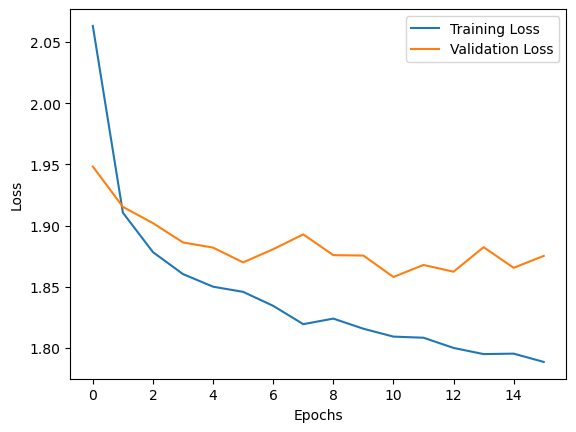

In [47]:
# LSTM
model0 = Sequential()
model0.add(InputLayer((20, 86)))
model0.add(LSTM(64))
model0.add(BatchNormalization())
model0.add(Dropout(0.2)) 
model0.add(Dense(16, 'relu'))
model0.add(Dense(8, 'softmax'))  

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cp = ModelCheckpoint('model0/', save_best_only=True)
model0.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=.001))
history = model0.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stopping, cp], verbose=0)

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
model0 = load_model('model0/')

test_pred, test_prob, train_pred, train_prob, val_pred, val_prob = predict_lstm(X_train, X_val, X_test, model0)
classification_results(y_test, y_train, y_val, model0, train_pred, val_pred, test_pred, train_prob, val_prob, test_prob)

20/20 [==============================] - 0s 5ms/step
             Train  Validation      Test
Accuracy  0.336000    0.307692  0.328000
Log Loss  1.777228    1.858061  1.804873
ROC_AUC   0.637475    0.535138  0.550470
Training: 
              precision    recall  f1-score   support

         0.0       0.33      0.81      0.47      1305
         1.0       0.31      0.05      0.09       553
         2.0       0.36      0.37      0.36      1030
         3.0       0.24      0.02      0.04       529
         4.0       0.00      0.00      0.00       191
         5.0       0.00      0.00      0.00       270
         6.0       0.00      0.00      0.00       300
         7.0       0.00      0.00      0.00       197

    accuracy                           0.34      4375
   macro avg       0.16      0.16      0.12      4375
weighted avg       0.25      0.34      0.24      4375

Validation: 
              precision    recall  f1-score   support

         0.0       0.33      0.79      0.46       196

/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tom/anaconda3/lib/python3.1